In [23]:
import logging
import os.path
import sys

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch
from torch import nn
from tqdm.auto import tqdm
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from dgllife.utils import CanonicalAtomFeaturizer

from rdkit import Chem
from rdkit.Chem import AllChem
import exmol
import selfies as sf
import skunk
from cairosvg import svg2png

sys.path.append(os.path.abspath("../"))

from config import ROOT_DIR
from Source.models.GCNN_FCNN.model import GCNN_FCNN
from Source.models.GCNN.trainer import GCNNTrainer
from Source.trainer import ModelShell
from Source.data import balanced_train_valid_split, root_mean_squared_error
from Source.models.GCNN_FCNN.old_featurizer import ConvMolFeaturizer
from Source.models.GCNN_FCNN.featurizers import DGLFeaturizer, SkipatomFeaturizer, featurize_sdf_with_metal_and_conditions

# Model parameters

In [24]:
cv_folds = 5
seed = 23
batch_size = 64
epochs = 1000
es_patience = 100
train_sdf_folder = ROOT_DIR / "Data/OneM_cond_adds"
train_folder = ROOT_DIR / "Output/WithCondAdd/5fold/Ac_5fold_regression_2023_05_30_21_09_41"

In [25]:
targets = ({
               "name": "logK",
               "mode": "regression",
               "dim": 1,
               "metrics": {
                   "R2": (r2_score, {}),
                   "RMSE": (root_mean_squared_error, {}),
                   "MAE": (mean_absolute_error, {})
               },
               "loss": nn.MSELoss(),
           },)

In [26]:
model = ModelShell(GCNN_FCNN, train_folder)

# Exmol

In [27]:
class ModelExmol(torch.nn.Module):
    def __init__(self, base_model, metal, charge, temperature, ionic_str):
        super().__init__()
        self.device = base_model.device
        self.model = base_model
        self.metal = metal
        
        conditions = torch.tensor([[charge, temperature, ionic_str]])
        metal_features = SkipatomFeaturizer().featurize(metal)
        self.metal_x = torch.cat((metal_features, conditions), dim=-1).to(self.device)
        
    def forward(self, smiles, selfies):
        mol = Chem.MolFromSmiles(sf.decoder(selfies))
        graph = ConvMolFeaturizer().featurize(mol).to(self.device)
        graph.metal_x = self.metal_x
        
        return self.model(graph)["logK"].detach().item()

In [28]:
def draw_samples(compounds, image_size=200, mols_per_row=5):
    molecules = compounds["molecule"].tolist()
    metals = compounds["metal"].tolist()
    logKs = compounds["logK"].tolist()
    
    img = Chem.Draw.MolsToGridImage(molecules, molsPerRow=mols_per_row, subImgSize=(image_size, image_size),
                               legends=[f"{metal}: logK = {logK:.2f}" for metal, logK in zip(metals, logKs)])
    return img

## Load data

In [29]:
# test_metal = "Er"
# device = torch.device("cuda")

# path_to_sdf = str(ROOT_DIR / "Data/OneM_cond_adds/" / f"{test_metal}.sdf")
# dataset = featurize_sdf_with_metal_and_conditions(path_to_sdf=path_to_sdf,
#                                                   mol_featurizer=ConvMolFeaturizer(),
#                                                   metal_featurizer=SkipatomFeaturizer(),
#                                                   shuffle=False)
# molecules = [(mol, p) for mol in Chem.SDMolSupplier(path_to_sdf) if mol is not None
#              for p in mol.GetPropNames() if p.startswith("logK")]
# smiles = [Chem.MolToSmiles(mol) for mol, p in molecules]

In [30]:
import pickle

samples_folder = "../Output/exmol_samples_3k_patterns"

samples = {}
for filename in tqdm(os.listdir(samples_folder), desc="Read samples"):
    with open(os.path.join(samples_folder, filename), "rb") as file:
        samples[filename] = pickle.load(file)

Read samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
other_metals = ['Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Mo', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs', 'Ba', 'Hf', 'Re',
                'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi']
Ln_metals = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', ]
Ac_metals = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf']

metals = list(set(["Y", "Sc"] + Ln_metals + Ac_metals) - {"Ac", "Pa"})
ind = np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()
metals = np.array(metals)[ind].tolist()

In [32]:
patterns = {
        "ether": ["O=C(O)COCC(=O)O", "CC(OC(C)C(=O)O)C(=O)O", "CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)N(CCCCCCCC)CCCCCCCC",
                  "CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)N(CCCCCCCC)CCCCCCCC",
                  "CCCCCCCCN(CCCCCCCC)C(=O)CO[C@@H](C)C(=O)N(CCCCCCCC)CCCCCCCC", "O=C(O)C1OC(C(=O)O)C(C(=O)O)C1C(=O)O"],
        "biPy": ["CCN(C(=O)c1cccc(-c2cccc(C(=O)N(CC)c3ccccc3)n2)n1)c1ccccc1",
                 "c1ccc(-c2ccc3ccc4ccc(-c5ccccn5)nc4c3n2)nc1",
                 "CCCCCCCCN(CCCCCCCC)C(=O)c1cccc(-c2cccc(C(=O)N(CCCCCCCC)CCCCCCCC)n2)n1",
                 "CCCCN(CCCC)C(=O)c1cccc(-c2cccc(C(=O)N(CCCC)CCCC)n2)n1", "c1ccc(-c2ccccn2)nc1",
                 "O=S(O[Na])c1cccc(-c2nnc(-c3cccc(-c4cccc(-c5nnc(-c6cccc(S(=O)O[Na])c6)c(-c6cccc(S(=O)O[Na])c6)n5)n4)n3)nc2-c2cccc(S(=O)O[Na])c2)c1",
                 "c1ccc(-c2cccc(-c3nnn[nH]3)n2)[nH+]c1",
                 "CCN(C(=O)c1cc([N+](=O)[O-])cc(-c2cc([N+](=O)[O-])cc(C(=O)N(CC)c3ccccc3)n2)n1)c1ccccc1",
                 "CCN(C(=O)c1cccc(-c2cccc(C(=O)N(CC)c3ccc(F)cc3)n2)n1)c1ccc(F)cc1",
                 "CCN(C(=O)c1cccc(-c2cccc(C(=O)N(CC)c3cccc(F)c3)n2)n1)c1cccc(F)c1",
                 "CCCCCc1nnc(-c2cccc(-c3ccccn3)n2)nc1CCCCC",
                 "CC1(C)CCC(C)(C)c2nc(-c3cccc(-c4cccc(-c5nnc6c(n5)C(C)(C)CCC6(C)C)n4)n3)nnc21",
                 "CCCCCc1nnc(-c2cccc(-c3cccc(-c4nnc(CCCCC)c(CCCCC)n4)n3)n2)nc1CCCCC"],
        "phenanthroline": ["c1ccc(-c2ccc3ccc4ccc(-c5ccccn5)nc4c3n2)nc1", "OCc1ccc2ccc3ccc(CO)nc3c2n1",
                           "NC(=O)c1ccc2ccc3ccc(C(N)=O)nc3c2n1",
                           "c1ccc2nc(-c3ccc4ccc5ccc(-c6ncc7ccccc7n6)nc5c4n3)ncc2c1",
                           "CC(C)(C)NCc1ccc2ccc3ccc(CNC(C)(C)C)nc3c2n1"],
        "Py": ["O=C(O)c1cccc(C(=O)O)n1", "CC(C)N(C(=O)c1cccc(C(=O)N(C(C)C)C(C)C)n1)C(C)C",
               "O=C(O)c1cccc(CN2CCOCCOCCN(Cc3cccc(C(=O)O)n3)CCOCCOCC2)n1", "Cc1cccc(CN(CC(=O)O)CC(=O)O)n1",
               "CCN(CC)C(=O)c1cccc(C(=O)N(CC)CC)n1", "O=C(c1cccc(C(=O)N(Cc2ccccc2)Cc2ccccc2)n1)N(Cc1ccccc1)Cc1ccccc1",
               "O=C(O)CN1CCCN(CC(=O)O)Cc2cccc(n2)CN(CC(=O)O)CCC1",
               "O=C(O)c1cccc(CN(CCN(Cc2cccc(C(=O)O)n2)Cc2cccc(C(=O)O)n2)Cc2cccc(C(=O)O)n2)n1",
               "O=P(O)(O)CN(Cc1cccc(CN(CP(=O)(O)O)CP(=O)(O)O)n1)CP(=O)(O)O", "Nc1cc(C(=O)O)nc(C(=O)O)c1",
               "C1=CC(c2ncc3ccccc3n2)=NC2C1=CCc1ccc(-c3ncc4ccccc4n3)nc12",
               "CCCc1nnc(-c2cccc(-c3nnc(CCC)c(CCC)n3)n2)nc1CCC",
               "Cc1cccc(C(=O)O)n1", "O=C(O)CN(CCN(CC(=O)O)c1cccc(C(=O)O)n1)Cc1cccc(C(=O)O)n1",
               "O=C(O)c1cccc(CN2CCOCCOCCN(Cc3cccc(C(=O)O)n3)CCOCC2)n1",
               "CC[C@@H](C)n1c(-c2cccc(-c3nc4ccccc4n3[C@@H](C)CC)n2)nc2ccccc21",
               "O=C(O)CN(CCCN(CC(=O)O)c1cccc(C(=O)O)n1)Cc1cccc(C(=O)O)n1",
               "O=S(=O)(O[Na])c1cccc(-c2nnc(-c3cccc(-c4nnc(-c5cccc(S(=O)(=O)O[Na])c5)c(-c5cccc(S(=O)(=O)O[Na])c5)n4)n3)nc2-c2cccc(S(=O)(=O)O[Na])c2)c1"],
        "EDTA": ["O=C(O)CN(CC(=O)O)CC(C(=O)O)N(CC(=O)O)CC(=O)O", "CC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "CCCCCCC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "CC(C)(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCCOC(=O)C1", "O=C(O)CN(CC(=O)O)C1CCCCC1N(CC(=O)O)CC(=O)O",
                 "CCC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "O=C(O)CN(CC(=O)O)[C@@H]1CCCC[C@H]1N(CC(=O)O)CC(=O)O",
                 "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCCOCCOCCOC(=O)C1", "CC(C(C)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O", "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCOCOCOCCOC(=O)C1",
                 "O=C(O)CN1CCNC(=O)CN(CC(=O)O)CCN(CC(=O)O)CC(=O)NCC1", "CCCCC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCCOCCOC(=O)C1", "CCCC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "CCCCCC[C@@H](CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "C[C@@H](CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "CCCC[C@@H](CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O",
                 "O=C(O)CNC(=O)CN(CCN(CC(=O)O)CC(=O)NCC(=O)O)CC(=O)O",
                 "O=C(O)CN(CC(=O)O)C[C@@H](C(=O)O)N(CC(=O)O)CC(=O)O",
                 "O=C(O)CN(CC(=O)O)[C@@H]1CCCC[C@@H]1N(CC(=O)O)CC(=O)O",
                 "CCC[C@@H](CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "O=C(O)CN(CCN(CC(=O)O)C(C(=O)O)C1CCCCC1O)CC(=O)O"],
}

In [57]:
pattern = "Py"

folder = str(ROOT_DIR / "Data/OneM_cond_adds/")

df = pd.DataFrame(columns=["smiles", "molecule", "metal", "T", "I", "z", "samples"])
molecules = [Chem.MolFromSmiles(s) for s in patterns[pattern]]
z = 3; T = 25; I = 0.1

i = 0
for metal in metals:
    for mol, s in zip(molecules, patterns[pattern]):
        sample = samples[f"{metal}_T={T}_I={I}_z={z}_{len(s)}.pkl"]
        df.loc[i] = [s, mol, metal, T, I, z, sample]
        i += 1

In [58]:
# df = pd.DataFrame(columns=["smiles", "molecule", "graph", "metal", "T", "I", "z", "logK", "samples"])

# folder = str(ROOT_DIR / "Data/OneM_cond_adds/")
# i = 0
# for metal in tqdm(metals, desc="Metals"):
#     dataset = featurize_sdf_with_metal_and_conditions(path_to_sdf=os.path.join(folder, f"{metal}.sdf"),
#                                                       mol_featurizer=ConvMolFeaturizer(),
#                                                       metal_featurizer=SkipatomFeaturizer(),
#                                                       shuffle=False)
#     molecules = [(mol, p) for mol in Chem.SDMolSupplier(os.path.join(folder, f"{metal}.sdf")) if mol is not None
#                  for p in mol.GetPropNames() if p.startswith("logK")]
#     smiles = [Chem.MolToSmiles(mol) for mol, p in molecules]
#     for graph, (mol, prop_name), s in zip(dataset, molecules, smiles):
#         _, metal, z, T, I = prop_name.split("_")
#         z = float(z.split("=")[1])
#         T = float(T.split("=")[1])
#         I = float(I.split("=")[1])
#         logK = float(mol.GetProp(prop_name))
#         sample = samples[f"{metal}_T={T}_I={I}_z={z}_logK={logK}_{len(s)}.pkl"]
#         df.loc[i] = [s, mol, graph, metal, T, I, z, logK, sample]
#         i += 1

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 0 to 449
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   smiles    450 non-null    object 
 1   molecule  450 non-null    object 
 2   metal     450 non-null    object 
 3   T         450 non-null    int64  
 4   I         450 non-null    float64
 5   z         450 non-null    int64  
 6   samples   450 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 28.1+ KB


## t-statistics

In [60]:
def get_t_statistics(examples, beta):
    assert examples[0].is_origin
    bit_info = {}
    mol = Chem.MolFromSmiles(examples[0].smiles)
    AllChem.GetMorganFingerprint(mol, 3, bitInfo=bit_info)
    
    # t = examples[0].descriptors.tstats
    t = beta
    mask = ~np.isnan(t)

    t = t[mask].tolist()
    keys = np.array(examples[0].descriptors.descriptor_names, dtype=int)[mask].tolist()
    names = np.array(examples[0].descriptors.plotting_names, dtype=object)[mask].tolist()
    return pd.DataFrame({"t": t, "key": keys, "name": names, "smiles": examples[0].smiles, "mol": [mol] * len(t), "bit_info": [bit_info] * len(t)}, index=range(len(t)))

Calculate t-statistics on samples around each molecule

In [61]:
from collections import Counter

min_count = 3
# save_folder = f"../Output/exmol_t_statistics_3k_samples_patterns/{pattern}"
save_folder = f"../Output/exmol_beta_3k_samples_patterns/{pattern}"

t_dfs = {}
os.makedirs(save_folder, exist_ok=True)
for f in os.listdir(save_folder):
    metal = f.split(".")[0]
    t_dfs[metal] = pd.read_csv(os.path.join(save_folder, f))

for metal in tqdm(df["metal"].unique()):    
    if metal in t_dfs: continue
    dfs = []
    for s in tqdm(df[df["metal"] == metal]["samples"], desc=metal, leave=False):
        beta = exmol.lime_explain(s, descriptor_type='ECFP', return_beta=True)
        dfs += [get_t_statistics(s, beta)]

    t_df = pd.concat(dfs, ignore_index=True)
    common_keys = [key for key, count in Counter(t_df["key"]).items() if count > min_count]
    filter_ids = [i for i in t_df.index if t_df["key"][i] in common_keys]
    t_dfs[metal] = t_df.loc[filter_ids]
    t_dfs[metal].to_csv(os.path.join(save_folder, f"{metal}.csv"), index=False)
    
for t_df in tqdm(t_dfs.values(), desc="fix saving problems"):
    if t_df.shape[0] == 0: continue
    if type(t_df["mol"][0]) == str:
        t_df["mol"] = pd.Series([Chem.MolFromSmiles(s) for s in t_df["smiles"]])
    if type(t_df["bit_info"][0]) == str:
        t_df["bit_info"] = [eval(bi) for bi in t_df["bit_info"]]
        
for t_df in tqdm(t_dfs.values(), desc="drop duplicates"):
    t_df.drop_duplicates(subset=["smiles", "key", "t"], inplace=True)

  0%|          | 0/25 [00:00<?, ?it/s]

fix saving problems:   0%|          | 0/25 [00:00<?, ?it/s]

drop duplicates:   0%|          | 0/25 [00:00<?, ?it/s]

Calculate `mean` and `std` of t-values

In [62]:
mean_t_dfs = []
for metal in tqdm(t_dfs, desc="Metals"):
    for key in t_dfs[metal]["key"].unique():
        subdf = t_dfs[metal][t_dfs[metal]["key"] == key]
        subdf["name"].tolist()
        t = subdf["t"].to_numpy()
        mean_t_dfs += [pd.DataFrame({
            "metal": [metal],
            "key": [int(key)],
            "mean": [t.mean()],
            "std": [t.std()],
            "n_samples": [len(t)],
            "mol": [subdf["mol"].tolist()[0]],
            "bit_info": [subdf["bit_info"].tolist()[0]],
            "name": [subdf["name"].tolist()[0]],
        }, index=[0])]

mean_t_df = pd.concat(mean_t_dfs, ignore_index=True)
mean_t_df = mean_t_df[mean_t_df["n_samples"] > min_count]

Metals:   0%|          | 0/25 [00:00<?, ?it/s]

In [63]:
mean_t_df

,metal,key,mean,std,n_samples,mol,bit_info,name
0,Dy,1101907775,1.047048,1.871676,14,<rdkit.Chem.rdchem.Mol object at 0x7fa85614da50>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",hetero N nonbasic/aromatic group
1,Dy,98513984,-0.444170,1.064288,11,<rdkit.Chem.rdchem.Mol object at 0x7fa7ed605200>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",aromatic
2,Dy,2784506312,1.192277,0.407578,6,<rdkit.Chem.rdchem.Mol object at 0x7fa7ed605190>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",carboxylic acid/aromatic group
3,Dy,1510328189,-0.385529,2.280748,12,<rdkit.Chem.rdchem.Mol object at 0x7fa7ed605120>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",carbonyl
4,Dy,1222002934,0.146860,0.574236,5,<rdkit.Chem.rdchem.Mol object at 0x7fa7ed6050b0>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",carboxylic acid/hetero N nonbasic/aromatic group
...,...,...,...,...,...,...,...,...
216,Yb,1101907775,1.183819,1.686161,14,<rdkit.Chem.rdchem.Mol object at 0x7fa7f0343dd0>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",hetero N nonbasic/aromatic group
217,Yb,98513984,-0.448055,0.949249,11,<rdkit.Chem.rdchem.Mol object at 0x7fa7f0343e40>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",aromatic
218,Yb,2784506312,1.210314,0.789350,6,<rdkit.Chem.rdchem.Mol object at 0x7fa7f0343eb0>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",carboxylic acid/aromatic group
219,Yb,1510328189,-0.384738,1.851430,12,<rdkit.Chem.rdchem.Mol object at 0x7fa7f0343f20>,"{22280398: ((3, 3), (7, 3)), 77216203: ((8, 2)...",carbonyl


In [64]:
from matplotlib.offsetbox import AnnotationBbox
from PIL import Image
import io

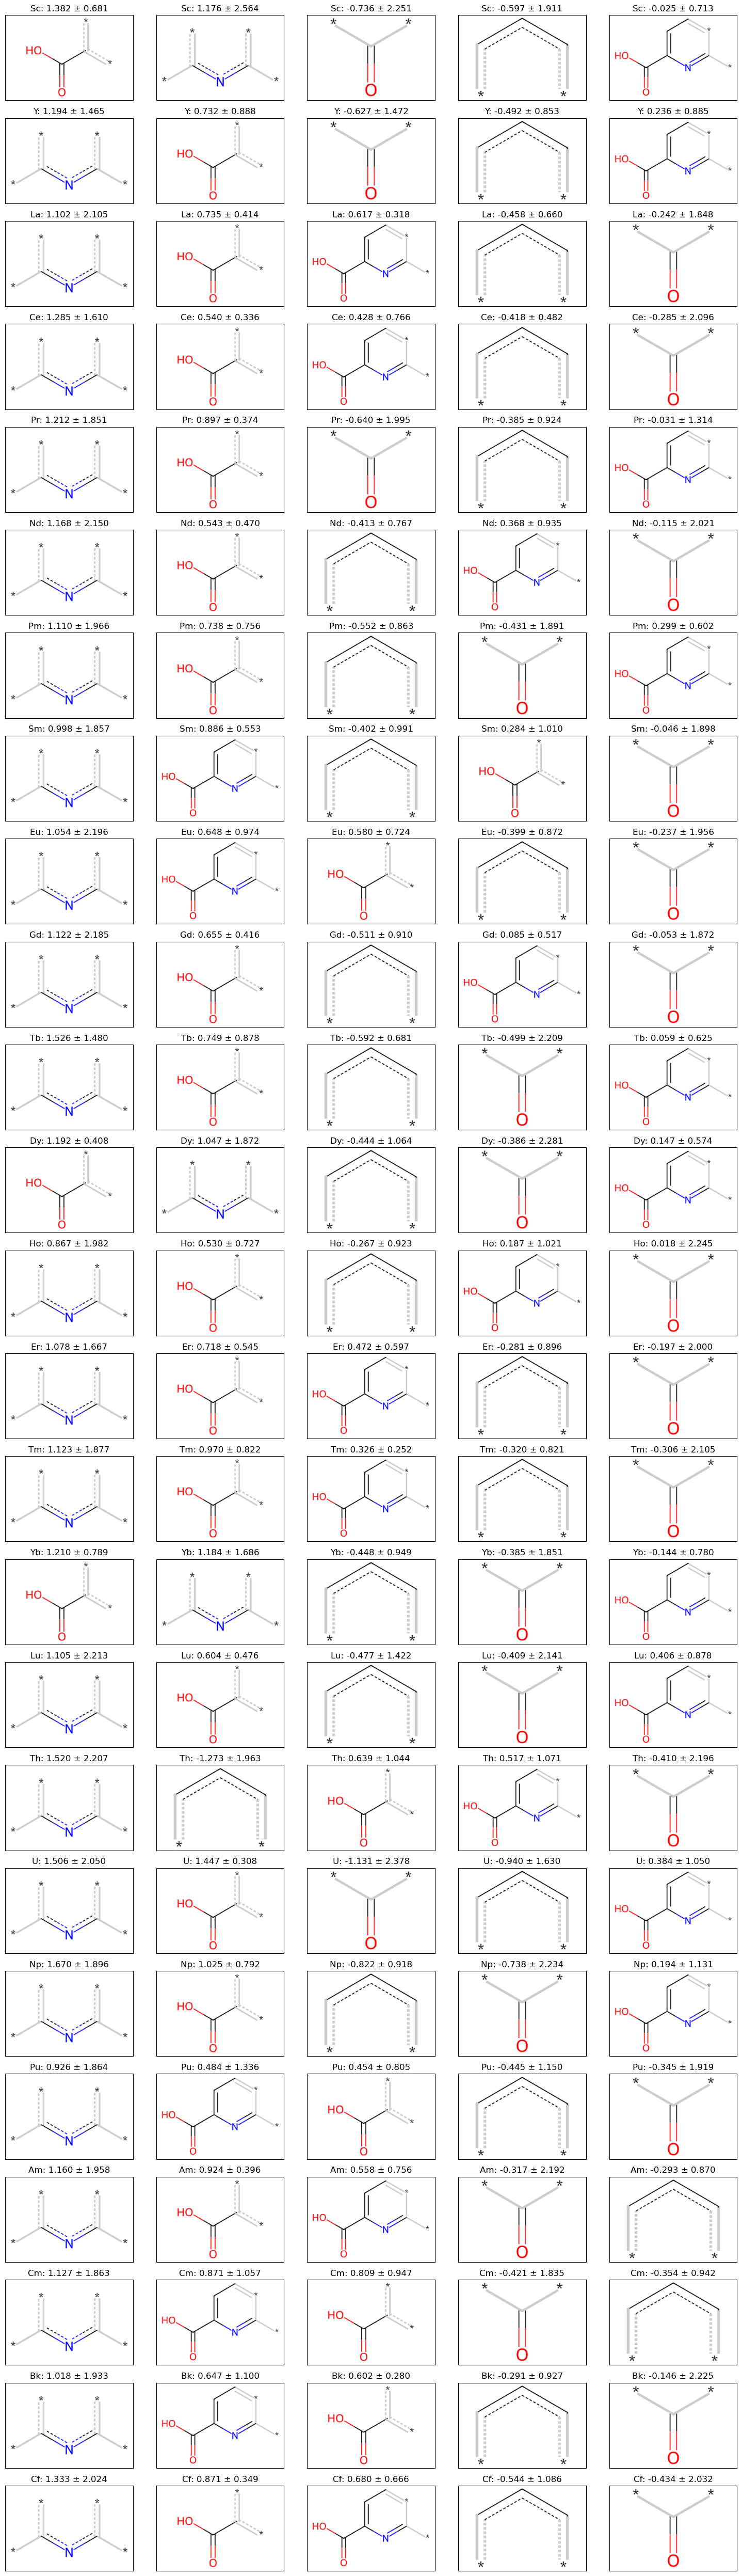

In [65]:
top_n = 5
imgs_per_row = 5
image_size = (3, 2)

cols = top_n
rows = len(mean_t_df["metal"].unique())
fig, axs = plt.subplots(rows, cols, figsize=(image_size[0]*cols, image_size[1]*rows))

metals = mean_t_df["metal"].unique()
ind = np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()
metals = np.array(metals)[ind]


for i, metal in enumerate(metals):
    sorted_ids = mean_t_df[mean_t_df["metal"] == metal].sort_values(by="mean", ascending=False, key=lambda v: abs(v)).index
    sub_df = mean_t_df[mean_t_df["metal"] == metal].loc[sorted_ids].iloc[:top_n]
    for j, (_, row) in enumerate(sub_df.iterrows()):
        svg = Chem.Draw.DrawMorganBit(
            row["mol"],
            int(row["key"]),
            row["bit_info"],
            molSize=(300, 200),
            centerColor=None,
            aromaticColor=None,
            ringColor=None,
            extraColor=(0.8, 0.8, 0.8),
            useSVG=True,
        )
        axs[i, j].imshow(Image.open(io.BytesIO(svg2png(svg.data))))
        axs[i, j].set_title(f"{row['metal']}: {row['mean']:.3f} ± {row['std']:.3f}")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout(h_pad=1, w_pad=0)
plt.show()
# break

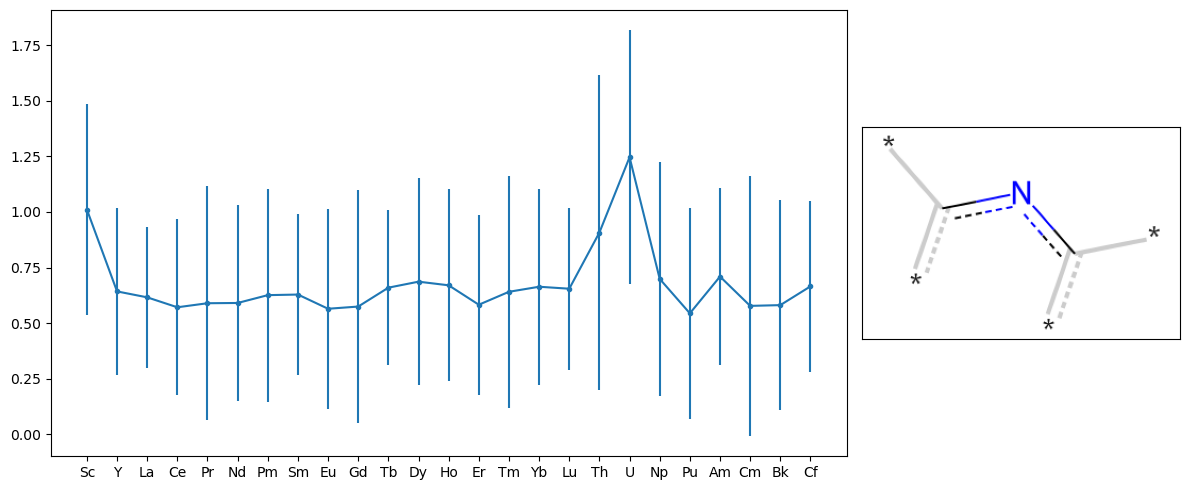

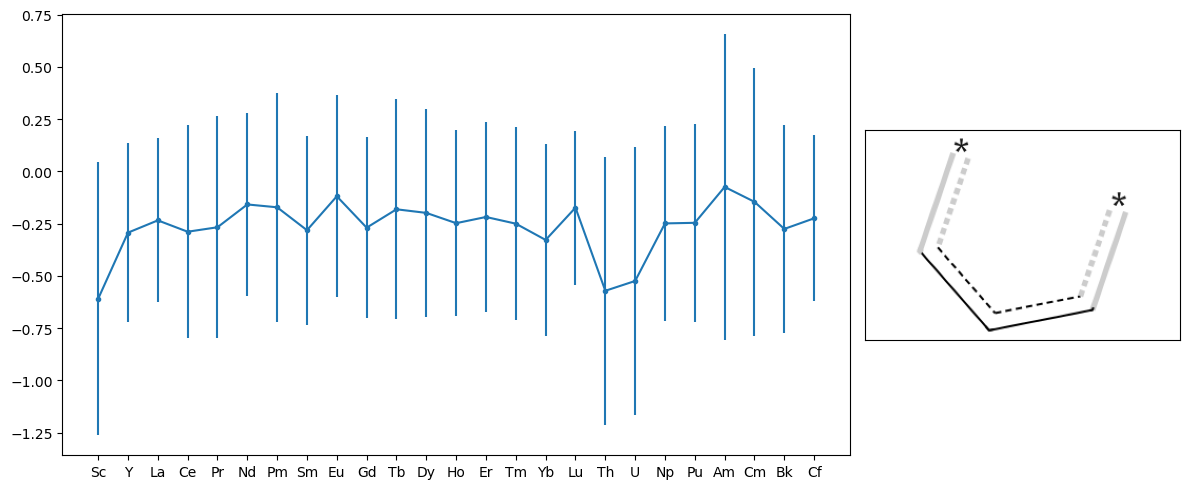

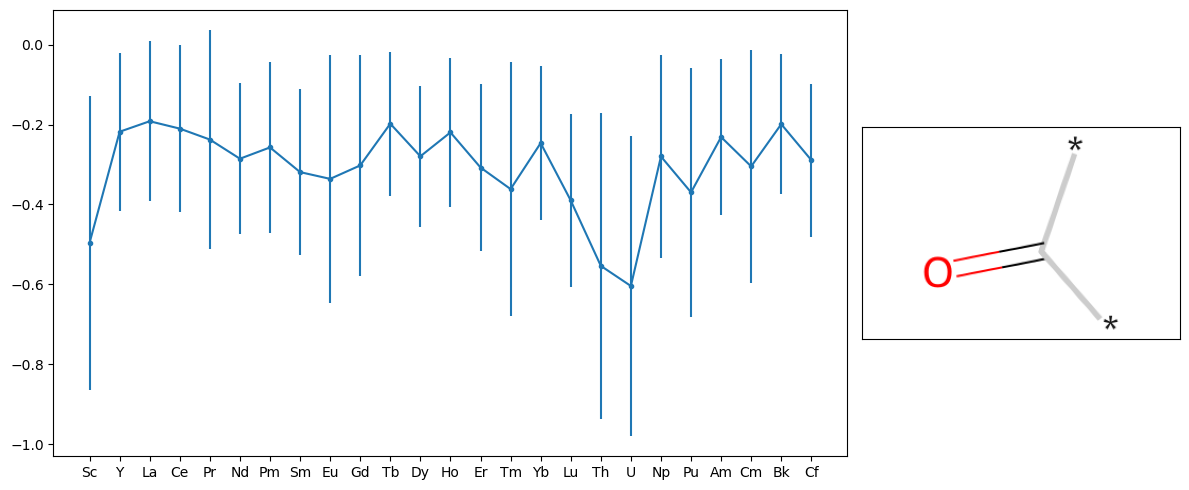

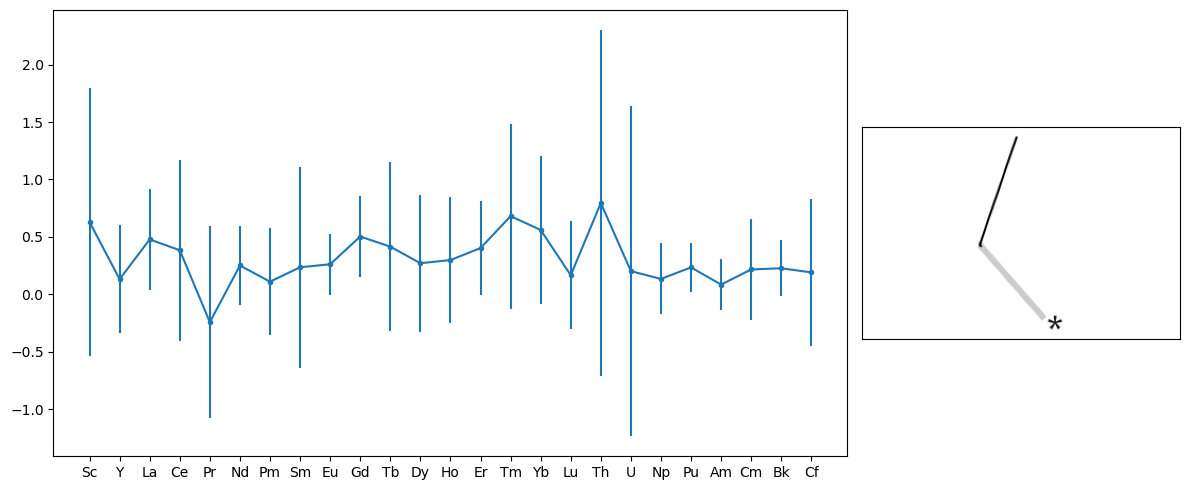

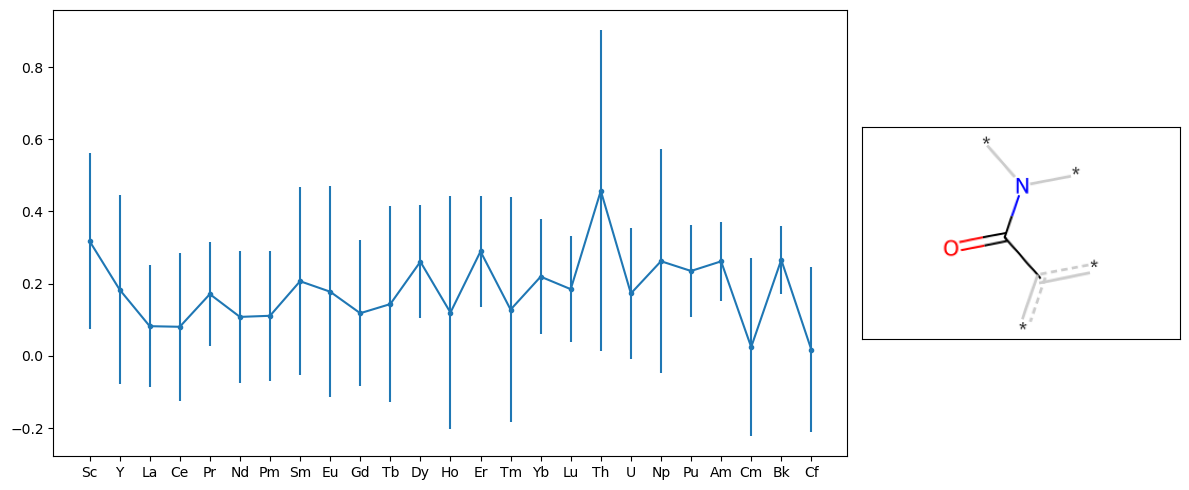

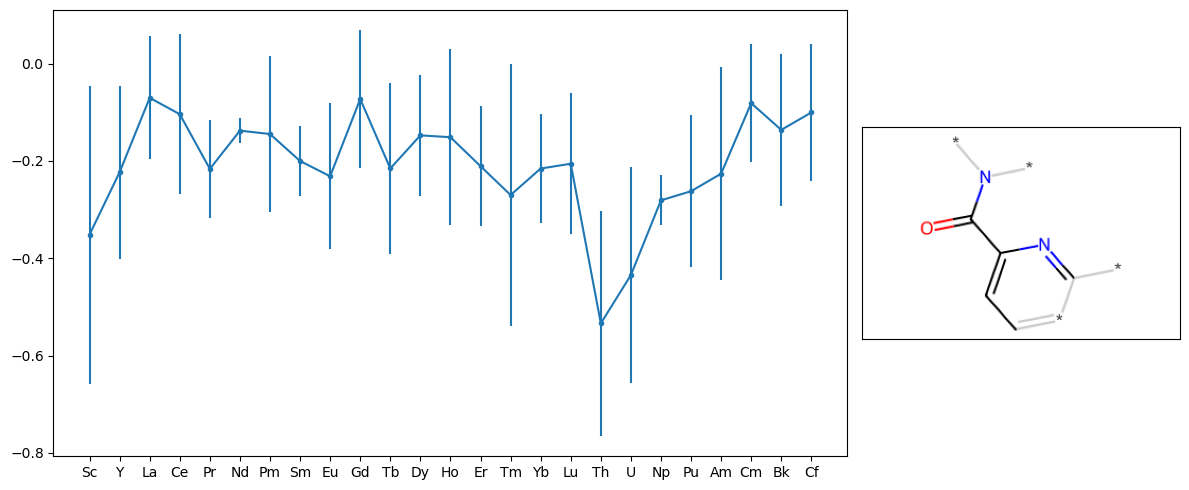

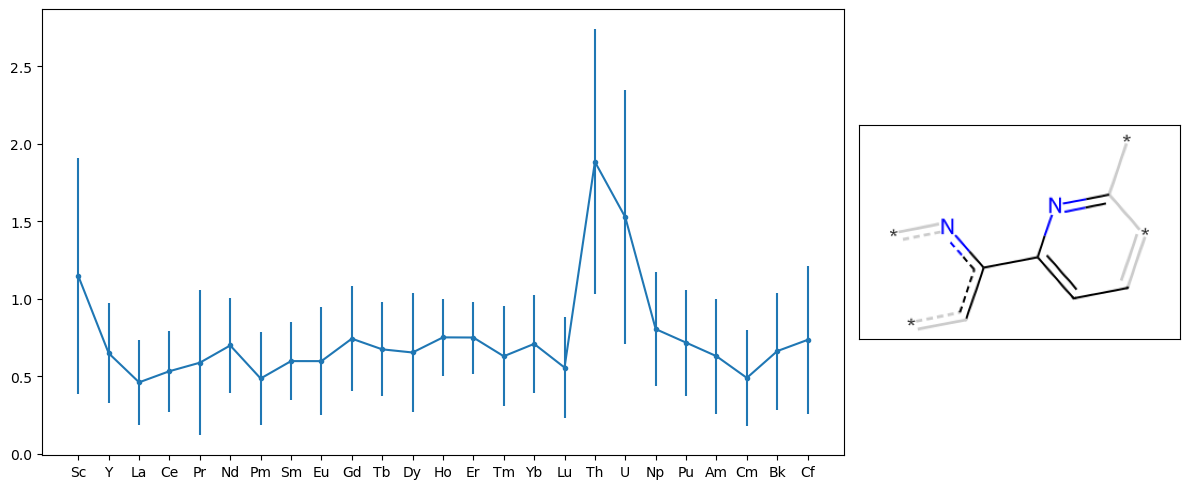

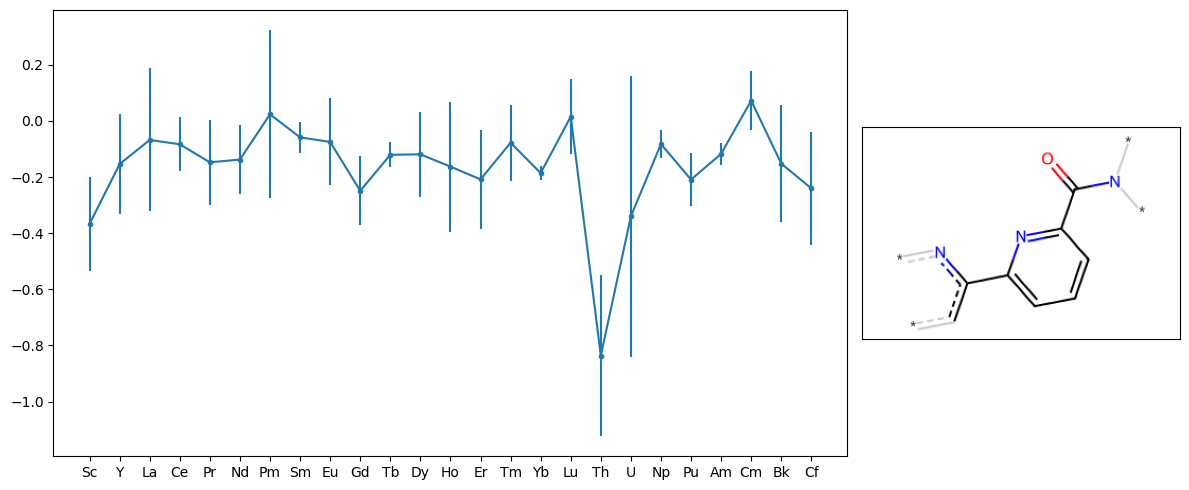

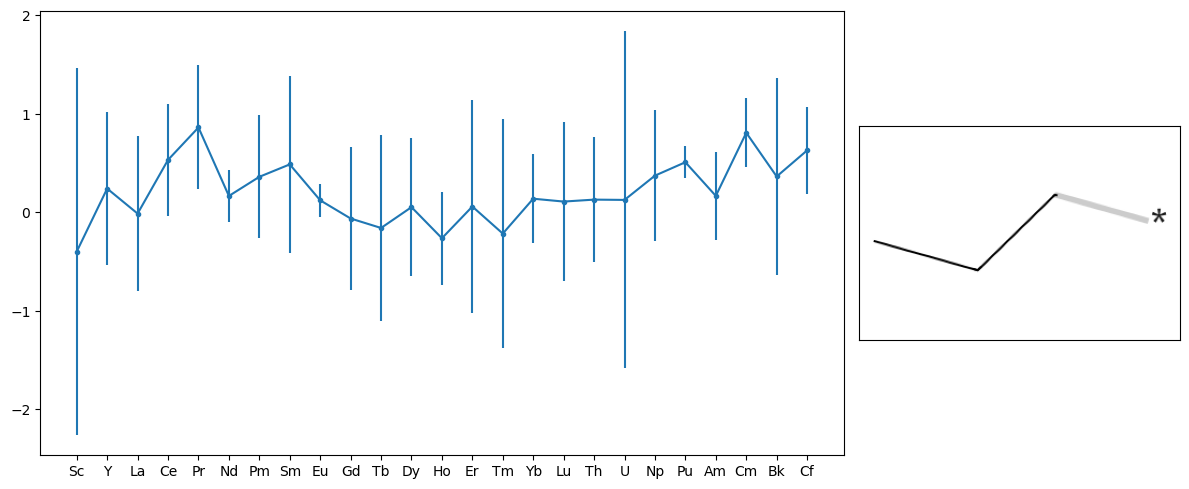

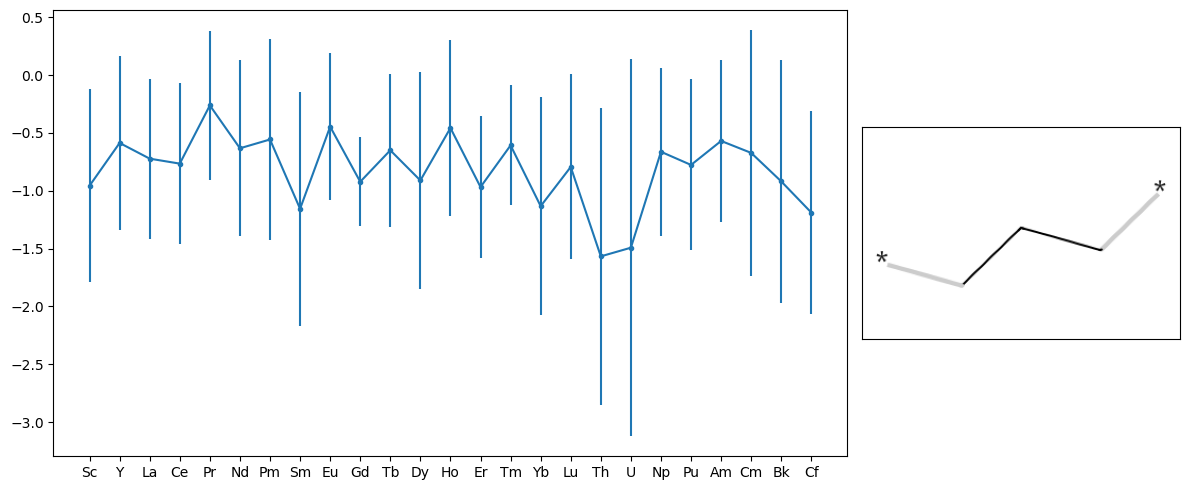

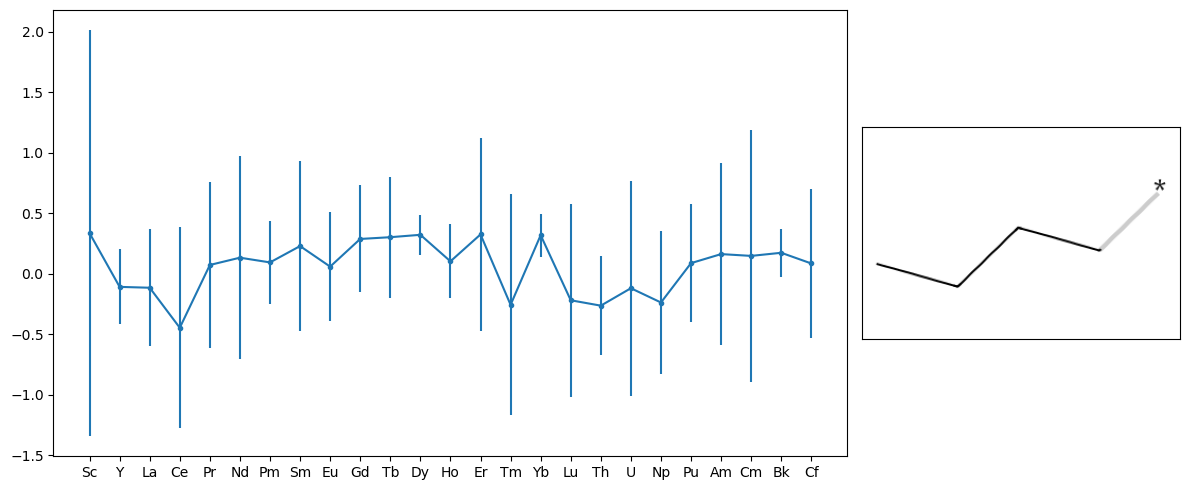

In [51]:
images = []

for key in mean_t_df["key"].unique():
    tmp_df = mean_t_df[mean_t_df["key"] == key]

    svg = Chem.Draw.DrawMorganBit(
        tmp_df["mol"].tolist()[0],
        int(tmp_df["key"].tolist()[0]),
        tmp_df["bit_info"].tolist()[0],
        molSize=(300, 200),
        centerColor=None,
        aromaticColor=None,
        ringColor=None,
        extraColor=(0.8, 0.8, 0.8),
        useSVG=True,
    )

    ind = np.array([Chem.Atom(metal).GetAtomicNum() for metal in tmp_df["metal"]]).argsort()

    mean = tmp_df["mean"].to_numpy()[ind]
    std = tmp_df["std"].to_numpy()[ind]
    metal = tmp_df["metal"].to_numpy()[ind]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), width_ratios=(2.5, 1))

    ax[1].imshow(Image.open(io.BytesIO(svg2png(svg.data))))
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[0].errorbar(range(len(mean)), mean, yerr=std, fmt=".-")
    ax[0].set_xticks(range(len(metal)), metal)
    plt.tight_layout()
    
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    Image.open(buf)
    images += [Image.open(buf).convert('RGB')]

pdf_path = f"../Output/{pattern}.pdf"
images[0].save(pdf_path, "PDF", resolution=100.0, save_all=True, append_images=images[1:])

Dy: 1.192 ± 0.408


[]

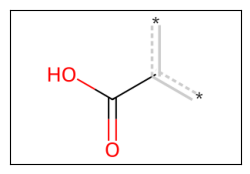

In [67]:
fig, ax = plt.subplots(figsize=(3, 2))
metal = "Dy"
top_k = 1
sorted_ids = mean_t_df[mean_t_df["metal"] == metal].sort_values(by="mean", ascending=False, key=lambda v: abs(v)).index
sub_df = mean_t_df[mean_t_df["metal"] == metal].loc[sorted_ids].iloc[[0]]
sub_df.reset_index(inplace=True, drop=True)
svg = Chem.Draw.DrawMorganBit(
    sub_df["mol"][0],
    int(sub_df["key"][0]),
    sub_df["bit_info"][0],
    molSize=(300, 200),
    centerColor=None,
    aromaticColor=None,
    ringColor=None,
    extraColor=(0.8, 0.8, 0.8),
    useSVG=True,
)

print(f"{sub_df['metal'][0]}: {sub_df['mean'][0]:.3f} ± {sub_df['std'][0]:.3f}")
with open(f"{pattern}_{metal}_top-{top_k}.svg", "w") as file:
    file.write(svg.data)

ax.imshow(Image.open(io.BytesIO(svg2png(svg.data))))
ax.set_xticks([])
ax.set_yticks([])